In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from datetime import datetime as dt, timedelta, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/packages/gpd_lite_toolbox')
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
from target_fire_functions import *
import itertools

In [3]:
#Load county grid and fire data
data_dir = data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'
county_grid = gpd.read_file(os.path.join(data_dir, 'clean_data/county_grid/county_grid.dbf'))
fire_data = gpd.read_file(os.path.join(data_dir, 'clean_data/fire_gis/fire_gis.dbf'))

In [4]:
fire_data['start_date'] = pd.to_datetime(fire_data['ALARM_DATE'], format = '%Y-%m-%d', errors = 'coerce')
fire_data['end_date'] = pd.to_datetime(fire_data['CONT_DATE'], format = '%Y-%m-%d', errors = 'coerce')
fire_data.drop(['ALARM_DATE', 'CONT_DATE'], axis = 1, inplace = True)
fire_data.dropna(subset = ['start_date', 'end_date'], inplace = True)
fire_data = fire_data[(fire_data['YEAR']>=1990) &  (fire_data['YEAR']<=2018)]

In [5]:
county_grid.rename(columns = {'COUNTY_ARE': 'COUNTY_AREA'}, inplace = True)

## Target Variable Creation

In [6]:
##Start by creating empty array into which we will fill data for selected timeframe and area
def generate_target_frame(grid_data, min_year, max_year):
    '''
    Purpose:
    --------
    Create shell target dataframe that has dates and grid ids broken down at all time intervals we may be interested in
    (days, weeks, and months - creating all of these at once reduces need to merge and combine dataframes later)
    Inputs:
    ------
        - grid_data : GeoDataFrame that will tell us the number of sections of the map for each we want to create observations
        - min_year : minimum year for which we want to include training data (inclusive)
        - max_year : max year for which we want to include training data (inclusive)
    Output(s):
    ---------
        - target_frame: pandas DataFrame w/ two columns
            1. date : will have all dates on the user input time interval between min and max input dates
            2. GRID_ID : column of grid ids for each date (i.e. will be colmn with lots of repeated grid ids)
                                     
    '''
    #get number of map sections
    n_areas = len(grid_data)
    #get number of time intervals
    years = max_year - min_year + 1
    
    #Generate day data first
    target_frame = pd.DataFrame(pd.date_range(f'1/1/{min_year}', f'12/31/{max_year}', freq = 'D'), columns = ['date'])
    print(target_frame.shape)
    #Get year, month, and week values from this date column
    target_frame['year'] = target_frame['date'].apply(lambda x:x.year)
    target_frame['month'] = target_frame['date'].apply(lambda x:x.month)
    target_frame['week'] = target_frame['date'].apply(lambda x:x.week)
    
    #Generate month data
    target_frame['month_id'] = target_frame['year'].astype(str) + '_' + target_frame['month'].astype(str)
    
    #get min and max date values for each month and then merge back onto full dataframe
    month_grp = target_frame[['month_id', 'date']].groupby(['month_id']).agg({'date' : ['min', 'max']}).reset_index()
    month_grp.columns = ['_'.join(col).strip() for col in month_grp.columns.values]
    month_grp.rename(columns = {'month_id_': 'month_id', 'date_min': 'month_start', 'date_max': 'month_end'}, \
                     inplace = True)
    target_frame = target_frame.merge(month_grp, on = 'month_id')
    
    #Generate week data - deal with weeks that start in december (assign them to the previous year)
    target_frame['week_id'] = np.where((target_frame['month'] ==12) & (target_frame['week'] ==1),
                                        target_frame['year'].apply(lambda x: str(x+1))+"_"+ target_frame['week'].astype(str), 
                                       target_frame['year'].astype(str) + '_' + target_frame['week'].astype(str))
    
    #get min and max date values for each month and then merge back onto full dataframe
    print(target_frame[(target_frame['week']==1) & (target_frame['month']==12)])
    week_grp = target_frame[['week_id', 'date']].groupby(['week_id']).agg({'date' : ['min', 'max']}).reset_index()
    week_grp.columns = ['_'.join(col).strip() for col in week_grp.columns.values]
    week_grp.rename(columns = {'week_id_': 'week_id', 'date_min': 'week_start', 'date_max': 'week_end'}, \
                     inplace = True)
    week_grp.sort_values(['week_start'], inplace = True)
    target_frame = target_frame.merge(week_grp, on = 'week_id')
    
    n_dates = len(target_frame)
    #Duplicate dates x # of times for grid sections we have
    target_frame = pd.concat([target_frame]*n_areas)
    target_frame['GRID_ID'] = list(itertools.chain(*[np.repeat(i, n_dates) for i in grid_data['GRID_ID'].sort_values()]))
    target_frame.drop(['year', 'month', 'week'], inplace = True, axis = 1)
    return target_frame

In [7]:
target_frame = generate_target_frame(county_grid, 1990, 2019)
target_frame.head()

(10957, 1)
            date  year  month  week month_id month_start  month_end week_id
364   1990-12-31  1990     12     1  1990_12  1990-12-01 1990-12-31  1991_1
728   1991-12-30  1991     12     1  1991_12  1991-12-01 1991-12-31  1992_1
729   1991-12-31  1991     12     1  1991_12  1991-12-01 1991-12-31  1992_1
2555  1996-12-30  1996     12     1  1996_12  1996-12-01 1996-12-31  1997_1
2556  1996-12-31  1996     12     1  1996_12  1996-12-01 1996-12-31  1997_1
2919  1997-12-29  1997     12     1  1997_12  1997-12-01 1997-12-31  1998_1
2920  1997-12-30  1997     12     1  1997_12  1997-12-01 1997-12-31  1998_1
2921  1997-12-31  1997     12     1  1997_12  1997-12-01 1997-12-31  1998_1
4382  2001-12-31  2001     12     1  2001_12  2001-12-01 2001-12-31  2002_1
4746  2002-12-30  2002     12     1  2002_12  2002-12-01 2002-12-31  2003_1
4747  2002-12-31  2002     12     1  2002_12  2002-12-01 2002-12-31  2003_1
5110  2003-12-29  2003     12     1  2003_12  2003-12-01 2003-12-31  2004_1
5

,date,month_id,month_start,month_end,week_id,week_start,week_end,GRID_ID
0,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
1,1990-01-02,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
2,1990-01-03,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
3,1990-01-04,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0
4,1990-01-05,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0.0


In [9]:
##Limit fire and grid data to just columns we need for target generate
grid_target_subset = county_grid[['NAME', 'COUNTYFP', 'COUNTY_AREA','GRID_AREA', 'GRID_ID', 'geometry']]
fire_target_subset = fire_data[['FIRE_AREA', 'FIRE_KEY', 'YEAR', 'start_date', 'end_date', 'geometry']]

In [10]:
print(fire_data[['start_date', 'end_date']].iloc[10])
pd.date_range(fire_data['start_date'].iloc[10], fire_data['end_date'].iloc[10], freq = 'w')

start_date   2007-10-22
end_date     2007-10-23
Name: 10, dtype: datetime64[ns]


DatetimeIndex([], dtype='datetime64[ns]', freq='W-SUN')

In [11]:
def disaggregate_fire_data(grid, fire_data):
    ''' 
    Purpose: Create instances of wildfires occuring on a daily level. This function starts with daily because it
    is easier to aggregate up once we have all days represented in one dataframe
    -------
    Inputs:
    -------
        - grid : GeoDataFrame of grid sections
        - fire_data : GeoDataFrame of fire data
    '''
    #Overlay grid and fire to get intersection geometry (this will create a dataframe with a few more fire
    #instances than we had in the plain fire_data 
    ##** Note that this will automatically exclude grid sections where this is no fire
    fire_grid = gpd.overlay(grid, fire_data, how = 'intersection')
    fire_grid['FIRE_GRID_INT_AREA'] = fire_grid.geometry.area
    fire_grid['FIRE_GRID_INT_AREA'] = fire_grid['FIRE_GRID_INT_AREA'].astype(float)
    fire_grid.index = range((len(fire_grid)))
    
    #create list of fires that had to be dropped due to data isseus (i.e. start date after end date)
    fires_dropped = []
    disagg_fire = pd.DataFrame()
    for row in fire_grid.itertuples():
        date_range = pd.date_range(row[list(fire_grid.columns).index('start_date')+1], \
                                   row[list(fire_grid.columns).index('end_date')+1], freq = 'D')
        if len(date_range) == 0:
            fires_dropped.append(row[list(fire_grid.columns).index('FIRE_KEY')])
            continue
        dup_fire_data = pd.concat([pd.Series(row[1:], index = list(fire_grid.columns)).to_frame().transpose()]*len(date_range))
        dup_fire_data['date'] = date_range
        disagg_fire = disagg_fire.append(dup_fire_data, ignore_index = True)
        if row[0] in(np.arange(0,9000, 250)):
            print(row[0], row[list(fire_grid.columns).index('GRID_ID')+1], len(disagg_fire))
            print(disagg_fire['date'].head())
    return disagg_fire, fires_dropped


In [13]:
fire_instances, fires_dropped = disaggregate_fire_data(grid_target_subset, fire_target_subset)

0 49.0 23
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
250 52.0 3324
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
500 90.0 4651
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
750 68.0 6283
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1000 102.0 8466
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1250 112.0 9121
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1500 114.0 9954
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
1750 11.0 11462
0   2007-09-03
1   2007-09-04
2   2007-09-05
3   2007-09-06
4   2007-09-07
Name: date, dtype: datetime64[ns]
2000 29.0 12

In [14]:
test = gpd.GeoDataFrame(fire_instances, geometry = fire_instances.geometry, crs={'init' :'epsg:3857'})
test_max = test[test['FIRE_GRID_INT_AREA']== test['FIRE_GRID_INT_AREA'].max()]

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

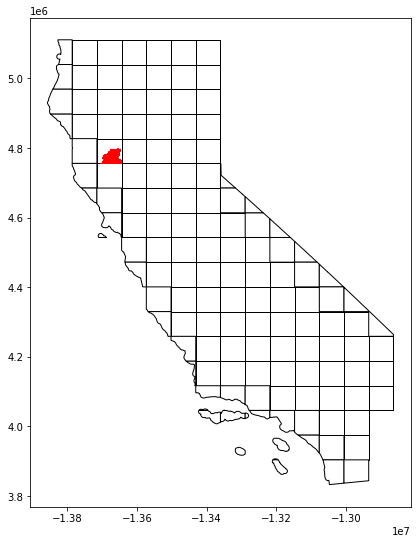

In [15]:
#Plot this fire data onto the grid
ax = county_grid.plot(color = 'white', edgecolor = 'black', figsize = (9,9))
test_max.plot(ax=ax, color = 'red', alpha = 0.5, figsize = (9,9))

Plot the sections of the grid where we apparently don't have fires against fire map just to make sure visually this tracks

Merge fire data onto full target dataframe of dates and grid sections that we've generated 

In [86]:
print(len(fire_instances))
print(len(target_frame))
target_full = pd.merge(target_frame, fire_instances,on = ['date', 'GRID_ID'], how = 'outer') 
target_full.head()
print(target_full.shape)

74445
1468238
(1492566, 19)


# Create full target dataframe will all target data options by different time intervals

### Option 1 : binary flag
Create binary 0,1 flag if wildfire occurred in a given grid section for a given time period 

In [87]:
target_full.sort_values('date', inplace = True)
target_full.head()
target_full['Y_bin'] = np.where(target_full['FIRE_KEY'].isna()== True, 0, 1)   

### Option 2: counts of fires
Count the number of distinct fires occurring in any one area on a given day 

In [88]:
target_fire_count = target_full[['date', 'GRID_ID', 'FIRE_KEY']].groupby(['date', 'GRID_ID']).count().reset_index()
target_fire_count.rename(columns = {'FIRE_KEY': 'Y_fire_count'}, inplace = True)
print(target_fire_count.shape)
#Merge onto target_options
target_full = target_full.merge(target_fire_count, on = ['date', 'GRID_ID'])
target_full.head()

(1468238, 3)


,date,month_id,month_start,month_end,week_id,week_start,week_end,GRID_ID,NAME,COUNTYFP,...,GRID_AREA,FIRE_AREA,FIRE_KEY,YEAR,start_date,end_date,geometry,FIRE_GRID_INT_AREA,Y_bin,Y_fire_count
0,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,None,NaN,0,0
1,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,118,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,None,NaN,0,0
2,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,None,NaN,0,0
3,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,117,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,None,NaN,0,0
4,1990-01-01,1990_1,1990-01-01,1990-01-31,1990_1,1990-01-01,1990-01-07,116,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaT,None,NaN,0,0


### Option 3: area of fires

In [89]:
target_full['FIRE_GRID_INT_AREA'].describe()

count     7.444500e+04
unique    6.442000e+03
top       3.601862e+06
freq      3.320000e+03
Name: FIRE_GRID_INT_AREA, dtype: float64

In [90]:
### Option 3: area of fires
target_full['FIRE_GRID_INT_AREA'] = target_full['FIRE_GRID_INT_AREA'].fillna(0).astype(float) 
print(target_full['FIRE_GRID_INT_AREA'].describe())
target_full['Y_fire_area_prop'] = np.where(target_full['FIRE_GRID_INT_AREA'].isna(), 0, 
                                           target_full['FIRE_GRID_INT_AREA']/target_full['GRID_AREA'])
target_full['Y_fire_area_prop'] = target_full['Y_fire_area_prop'].astype(float)
print(target_full[target_full['Y_fire_area_prop']!=0]['Y_fire_area_prop'].describe())

count    1.492566e+06
mean     2.036108e+06
std      2.920200e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.651920e+09
Name: FIRE_GRID_INT_AREA, dtype: float64
count    7.444500e+04
mean     8.496664e-03
std      2.589507e-02
min      1.826890e-09
25%      7.333799e-05
50%      7.145135e-04
75%      4.570981e-03
max      3.276969e-01
Name: Y_fire_area_prop, dtype: float64


### Option 4: fire class size

In [91]:
target_full['FIRE_ACRES'] = target_full['FIRE_AREA'].fillna(0)* 0.0002471054
print(target_full['FIRE_ACRES'].head())
print(target_full[target_full['FIRE_ACRES']!=0]['FIRE_ACRES'].describe())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FIRE_ACRES, dtype: float64
count     74445.000000
mean      12663.841653
std       40748.433972
min           0.001357
25%          62.979526
50%         552.472735
75%        5570.187226
max      410202.494043
Name: FIRE_ACRES, dtype: float64


In [92]:
## Uses NWCG fire size class code https://www.nwcg.gov/sites/default/files/data-standards/pdf/values.pdf
target_full['Y_fire_class_size'] = np.where(target_full['FIRE_ACRES']== 0, 0, 
                                          np.where((target_full['FIRE_ACRES']>0) &\
                                                   (target_full['FIRE_ACRES']<100), 1,
                                          np.where((target_full['FIRE_ACRES']>=100) & \
                                                   (target_full['FIRE_ACRES']<1000), 2,
                                                   np.where((target_full['FIRE_ACRES']>=1000) & \
                                                            (target_full['FIRE_ACRES']< 5000) , 3,
                                                            np.where(target_full['FIRE_ACRES']>=5000, 4, 0)))))

In [74]:
target_full['Y_fire_class_size'].value_counts()

0    1418121
1      21707
4      19125
2      19026
3      14587
Name: Y_fire_class_size, dtype: int64

In [93]:
target_full.drop(['NAME', 'COUNTYFP', 'COUNTY_AREA', 'GRID_AREA'], axis = 1, inplace = True)

In [94]:
target_full = target_full.merge(grid_target_subset[['NAME', 'COUNTYFP', 'COUNTY_AREA', 'GRID_AREA', 'GRID_ID']], on = ['GRID_ID'])

## Updated Target Variabales to Avoid Leakage

### Option 1: binary flag for a new fire in this month

In [95]:
target_full.sort_values('date', inplace = True)
target_full_month = target_full[['month_id', 'FIRE_KEY', 'Y_bin']].drop_duplicates()
target_full_month_fires = target_full_month[target_full_month['Y_bin']==1]
print(target_full_month_fires.shape)
target_full_month_fires_nodups = target_full_month_fires.drop_duplicates(['FIRE_KEY'], keep = 'first')
print(target_full_month_fires_nodups.shape)

(7963, 3)
(6026, 3)


In [96]:
target_full_month_fires_nodups['Y_bin_new_fire_month'] = 1
print(target_full.shape)
target_full = pd.merge(target_full, target_full_month_fires_nodups, on = ['month_id', 'FIRE_KEY', 'Y_bin'], how = 'outer')
print(target_full.shape)
target_full['Y_bin_new_fire_month'] = target_full['Y_bin_new_fire_month'].fillna(0)

<ipython-input-96-c269f977c809>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_full_month_fires_nodups['Y_bin_new_fire_month'] = 1


(1492566, 24)
(1492566, 25)


### Option 2: count of new fires in this month

In [97]:
count_new_fires = target_full_month_fires_nodups[['month_id', 'Y_bin_new_fire_month']].groupby('month_id').count().reset_index()
count_new_fires.rename(columns = {'Y_bin_new_fire_month':'Y_count_new_fires_month'}, inplace = True)
print(count_new_fires.head())
target_full = pd.merge(target_full, count_new_fires, on = 'month_id', how = 'outer')
print(target_full.shape)
target_full['Y_count_new_fires_month'] = target_full['Y_count_new_fires_month'].fillna(0)

  month_id  Y_count_new_fires_month
0  1990_10                        5
1  1990_11                        3
2  1990_12                        2
3   1990_3                        2
4   1990_4                        2
(1492566, 26)
        date month_id month_start  month_end week_id week_start   week_end  \
0 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
1 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
2 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
3 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
4 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   

  GRID_ID FIRE_AREA FIRE_KEY  ... Y_fire_count Y_fire_area_prop FIRE_ACRES  \
0       0       NaN      NaN  ...            0              NaN        0.0   
1     120       NaN      NaN  ...            0              NaN        0.0   
2      12       NaN      NaN  ...            0              NaN    

### Class size for new fires in the month

In [98]:
new_fire_class_size = target_full[target_full['Y_bin_new_fire_month']==1][['Y_fire_class_size', 'month_id']]
new_fire_class_size = new_fire_class_size.groupby('month_id').max().reset_index()
new_fire_class_size.rename(columns = {'Y_fire_class_size':'Y_max_new_fire_size_month'}, inplace = True)
target_full = pd.merge(target_full, new_fire_class_size, on = 'month_id', how = 'outer')
print(target_full.shape)
target_full['Y_max_new_fire_size_month'] = target_full['Y_max_new_fire_size_month'].fillna(0)
print(target_full.head())

(1492566, 27)
        date month_id month_start  month_end week_id week_start   week_end  \
0 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
1 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
2 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
3 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   
4 1990-01-01   1990_1  1990-01-01 1990-01-31  1990_1 1990-01-01 1990-01-07   

  GRID_ID FIRE_AREA FIRE_KEY  ... Y_fire_area_prop FIRE_ACRES  \
0       0       NaN      NaN  ...              NaN        0.0   
1     120       NaN      NaN  ...              NaN        0.0   
2      12       NaN      NaN  ...              NaN        0.0   
3      72       NaN      NaN  ...              NaN        0.0   
4     121       NaN      NaN  ...              NaN        0.0   

  Y_fire_class_size       NAME  COUNTYFP   COUNTY_AREA     GRID_AREA  \
0                 0  Del Norte       015  5.725577e+09

In [99]:
### Output full target data (note that the geometry in this is for the fire area in each grid section)
target_full_gpd = gpd.GeoDataFrame(target_full, geometry = target_full.geometry)

In [100]:
target_full_gpd['GRID_ID'] = target_full_gpd['GRID_ID'].astype(int)
target_full_gpd['YEAR'] = target_full_gpd['date'].apply(lambda x: x.year)
target_full_gpd['FIRE_AREA'] = target_full_gpd['FIRE_AREA'].astype(float)
target_full_gpd['COUNTYFP'] = target_full_gpd['COUNTYFP'].astype(int)
target_full_gpd.rename(columns = {'COUNTY_ARE': 'COUNTY_AREA'}, inplace= True)

#### Output target dataframe that does not have any aggregate columns (i.e. excluding no leakage targets)

In [103]:
target_full_noagg = target_full_gpd.drop(['Y_bin_new_fire_month', 'Y_max_new_fire_size_month', 'Y_count_new_fires_month'],
                                         axis = 1)
target_full_noagg.shape

(1492566, 24)

In [104]:
n_rows = np.round(len(target_full_noagg)/4,0).astype(int)
target_full_noagg.iloc[:n_rows].to_pickle(os.path.join(data_dir, 'clean_data/target_full_1.pkl'))
target_full_noagg.iloc[n_rows:2*n_rows].to_pickle(os.path.join(data_dir, 'clean_data/target_full_2.pkl'))
target_full_noagg.iloc[2*n_rows:3*n_rows].to_pickle(os.path.join(data_dir, 'clean_data/target_full_3.pkl'))
target_full_noagg.iloc[3*n_rows:].to_pickle(os.path.join(data_dir, 'clean_data/target_full_4.pkl'))

#### Output no leakage targets

In [108]:
no_leak_targets = target_full_gpd[['month_id', 'GRID_ID', 'Y_bin_new_fire_month', 'Y_max_new_fire_size_month', 
                                   'Y_count_new_fires_month']]
no_leak_targets.to_pickle(os.path.join(data_dir, 'clean_data/no_leakage_targets.pkl'))
no_leak_targets.to_csv(os.path.join(data_dir, 'clean_data/no_leakage_targets.csv'), index = False)

In [99]:
sub = target_full_gpd[['month_id', 'GRID_ID', 'Y_bin', 'Y_fire_count', 'FIRE_KEY']]

In [101]:
sub.to_csv(os.path.join(data_dir, 'clean_data/target_sub_adj.csv'))

In [88]:
target_full_gpd['Y_fire_class_size'].value_counts)

date                  datetime64[ns]
month_id                      object
month_start           datetime64[ns]
month_end             datetime64[ns]
week_id                       object
week_start            datetime64[ns]
week_end              datetime64[ns]
GRID_ID                       object
FIRE_AREA                     object
FIRE_KEY                      object
YEAR                          object
start_date            datetime64[ns]
end_date              datetime64[ns]
geometry                    geometry
FIRE_GRID_INT_AREA           float64
Y_bin                          int64
Y_fire_count                   int64
Y_fire_area_prop             float64
FIRE_ACRES                   float64
Y_fire_class_size              int64
NAME                          object
COUNTYFP                      object
COUNTY_ARE                   float64
GRID_AREA                    float64
dtype: object